In [22]:
import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt


from tqdm import tqdm
import time
import os
import pickle

import spect
import nb10

import imp

# **Load and proprocess data**

In [23]:
%%time
ds_bin = spect.decode_bins(
    dask.compute(
        xr.open_zarr('../data/temp_binned_1.zarr'), 
        scheduler='threads'
    )[0]
)

CPU times: user 6.88 s, sys: 3.68 s, total: 10.6 s
Wall time: 4.5 s


In [27]:
ds_bin

<xarray.Dataset>
Dimensions:          (sample_id: 1570, temp_bins: 1499, mz: 201, species: 10)
Coordinates:
  * mz               (mz) int64 200 201 202 203 204 205 ... 396 397 398 399 400
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
  * temp_bins        (temp_bins) object (0, 1] (1, 2] ... (1498, 1499]
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... nan nan nan
    number_of_obvs   (sample_id, temp_bins, mz) float64 0.0 0.0 0.0 ... nan nan
    split            (sample_id) object 'train' 'train' ... 'test' 'test'
    temp             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan
    time             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan

### Final dataset

In [29]:
ds_final = ds_bin.where(ds_bin.split=='train', drop=True)
ds_val = ds_bin.where(ds_bin.split=='val', drop=True)

ds_final

<xarray.Dataset>
Dimensions:          (sample_id: 766, temp_bins: 1499, mz: 201, species: 10)
Coordinates:
  * mz               (mz) int64 200 201 202 203 204 205 ... 396 397 398 399 400
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S0764' 'S0765'
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
  * temp_bins        (temp_bins) object (0, 1] (1, 2] ... (1498, 1499]
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    number_of_obvs   (sample_id, temp_bins, mz) float64 0.0 0.0 0.0 ... 0.0 0.0
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    temp             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan
    time             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan

# **Model**

## Functions

In [ ]:
#os.makedirs('nb11_results')

In [30]:
ds_train_test_splits = spect.cross_val_splits(ds_final, 8, random_seed=1549867, pairs=False)

In [40]:
type(df.sum(axis=0))

pandas.core.series.Series

In [51]:
row.index = [123]

In [61]:
x = {}
for s in range(10):
    x[f'species{s}']=[int(ds.labels.isel(species=s).sum().item()) for ds in ds_train_test_splits]
df = pd.DataFrame(x)
df['tot'] = df.sum(axis=1)
row = df.mean(axis=0)
row = row.to_frame().T

df = df/row.values
row.index = ['av']
df = df.append(row)
df

,species0,species1,species2,species3,species4,species5,species6,species7,species8,species9,tot
0,0.791209,0.979592,1.634409,1.041420,1.066667,0.755556,0.823045,0.538462,1.127517,1.555556,0.958927
1,1.406593,1.224490,1.204301,1.088757,0.266667,0.844444,1.053498,1.076923,0.859060,0.888889,1.032691
2,1.142857,1.142857,0.516129,0.946746,0.800000,0.933333,1.020576,1.230769,1.342282,0.666667,1.019279
3,1.054945,0.979592,1.032258,0.994083,1.333333,1.111111,1.053498,0.846154,0.859060,0.666667,0.999162
4,0.439560,0.653061,0.774194,0.852071,1.600000,0.977778,1.152263,0.923077,0.912752,0.888889,0.911987
5,0.967033,0.816327,0.946237,0.757396,0.266667,1.022222,1.020576,0.923077,0.805369,1.111111,0.905281
6,1.230769,1.306122,0.774194,1.041420,1.600000,1.111111,0.888889,1.384615,1.127517,2.000000,1.119866
7,0.967033,0.897959,1.118280,1.278107,1.066667,1.244444,0.987654,1.076923,0.966443,0.222222,1.052808
av,11.375000,12.250000,11.625000,21.125000,3.750000,22.500000,30.375000,13.000000,18.625000,4.500000,149.125000


In [38]:
imp.reload(nb10)
imp.reload(spect)

<module 'spect' from '/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/spect.py'>

In [ ]:
boosted = nb10.XG2CV(patience=10)
boosted.fit(ds_train_test_splits, same_params_all_columns=True, n_trials=100)
boosted.drop_studies()
with open(f'nb11_results/nb11-model-cv2.pkl','wb') as f:
    pickle.dump(boosted, f)

In [32]:
with open(f'nb11_results/nb11-model-cv2.pkl','rb') as f:
    boosted = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'nb11_results/nb11-model-cv2.pkl'

In [35]:
val_preds = boosted.predict_proba(ds_val, reduce=None)

[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.0s


In [36]:
l = nb10.xr_loss(val_preds, ds_val.labels)
l.mean(dim=('species'))

<xarray.DataArray (split: 8)>
array([0.1697627 , 0.16521768, 0.1491694 , 0.16969601, 0.16081007,
       0.1609432 , 0.17058802, 0.16909218])
Coordinates:
  * split    (split) int64 0 1 2 3 4 5 6 7

In [ ]:
l.mean()

In [158]:
def postprocess_extreme(preds):
    mn = preds.min(dim='split')
    mx = preds.max(dim='split')
    mean = preds.mean(dim='split')
    return mn.where(mean<0.5).fillna(0) + mx.where(mean>0.5).fillna(0)

In [159]:
l = nb10.xr_loss(postprocess_extreme(val_preds), ds_val.labels)
l.mean(dim=('species'))

<xarray.DataArray ()>
array(0.18601328)

In [80]:
l = nb10.xr_loss(val_preds.mean(dim='split'), ds_val.labels)
l.mean(dim=('species'))

<xarray.DataArray ()>
array(0.15007691)

In [86]:
def f(ds_target, ds_pred):
    return -(ds_target*np.log(ds_pred)+(1-ds_target)*np.log(1-ds_pred))
loss_full = f(ds_val.labels, val_preds.mean(dim='split'))
std_full = val_preds.std(dim='split')
y = loss_full.values.flatten()
x = std_full.values.flatten()

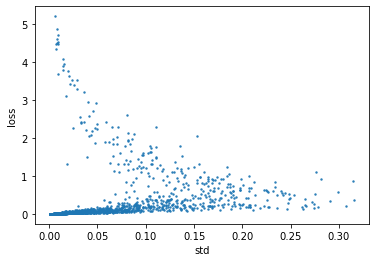

In [87]:
plt.plot(x, y, linestyle='', marker='.', markersize=3, alpha=.8)
plt.xlabel("std")
plt.ylabel("loss")
plt.show()

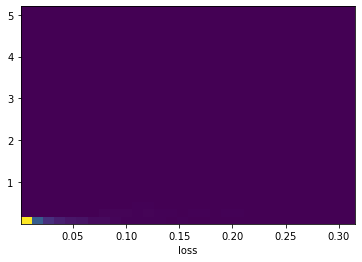

In [88]:
plt.hist2d(x, y, bins=30)
plt.xlabel("std")
plt.xlabel("loss")
plt.show()

In [89]:
-np.log(.9)

0.10536051565782628

Text(0, 0.5, 'mean loss')

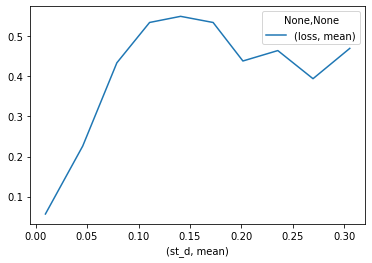

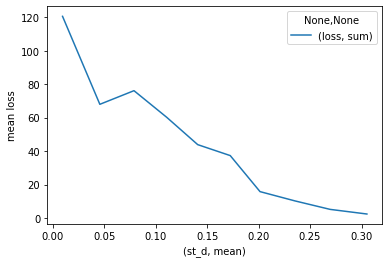

In [90]:
df = pd.DataFrame(dict(loss=y, st_d=x))
df['std_bin'] = pd.cut(df['st_d'],10)
df = df.groupby('std_bin').agg({'st_d':'mean', 'loss':['mean', 'sum']})


df.plot(x=('st_d', 'mean'), y=('loss', 'mean'))
df.plot(x=('st_d', 'mean'), y=('loss', 'sum'))
plt.ylabel('mean loss')

Errors come from where we are fairly sure of result, and I know it is often false negative, and that clipping to a minimum didn't work

In [91]:
loss_ens_mean = f(ds_val.labels, val_preds.mean(dim='split'))

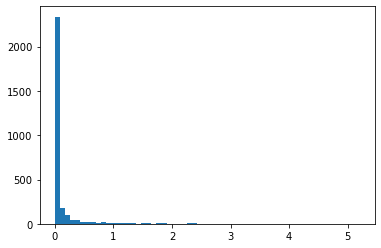

In [154]:
freq, bins, *_ = loss_ens_mean.plot.hist(bins=60)
plt.show()

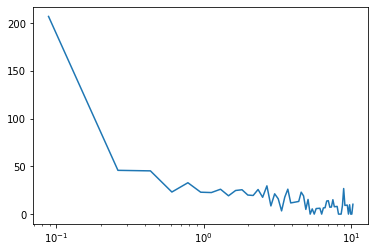

In [156]:
bc = (bins[1:]+bins[:-1])
plt.plot(bc, bc*freq)
plt.xscale('log')

This suggests most of the loss comes from where loss is small not skewed by a few large values.

In [127]:
bad_num = loss_ens_mean.max(dim='species').argmax(dim='sample_id').item()
bad_num

279

In [128]:
ds_val.isel(sample_id=bad_num)


<xarray.Dataset>
Dimensions:          (temp_bins: 1499, mz: 201, species: 10)
Coordinates:
  * mz               (mz) int64 0 1 2 3 4 5 6 7 ... 194 195 196 197 198 199 200
    sample_id        <U5 'S1045'
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
  * temp_bins        (temp_bins) object (0, 1] (1, 2] ... (1498, 1499]
Data variables:
    abundance        (temp_bins, mz) float64 nan nan nan nan ... nan nan nan nan
    instrument_type  object 'commercial'
    labels           (species) float64 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0
    number_of_obvs   (temp_bins, mz) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    split            object 'val'
    temp             (temp_bins) float64 nan nan nan nan nan ... nan nan nan nan
    time             (temp_bins) float64 nan nan nan nan nan ... nan nan nan nan

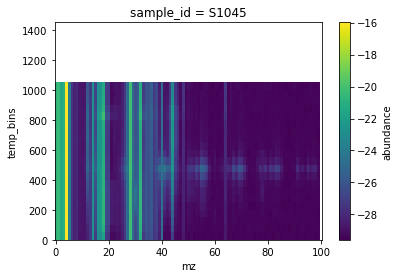

In [129]:
ds_bad = spect.rebin_data(ds_val.isel(sample_id=slice(bad_num, bad_num+1)), bins=np.arange(0, 1500, 50), mz_thresh=100).isel(sample_id=0)
np.log(ds_bad.abundance).plot()

In [162]:
val_preds.mean(dim='split').isel(sample_id=bad_num)

<xarray.DataArray 'preds' (species: 10)>
array([0.01071174, 0.00905635, 0.02384362, 0.48117983, 0.00450011,
       0.19949624, 0.9436011 , 0.00551901, 0.00284218, 0.00257587],
      dtype=float32)
Coordinates:
    sample_id  <U5 'S1045'
  * species    (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'

In [163]:
ds_bad.labels

<xarray.DataArray 'labels' (species: 10)>
array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0.])
Coordinates:
    sample_id  <U5 'S1045'
  * species    (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'

In [119]:
# None the same
len(ds_final.where((ds_final.labels==ds_bad.labels).all(dim='species'), drop=True).sample_id)

0

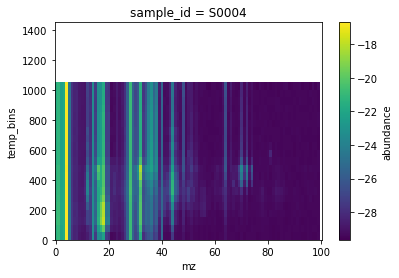

In [121]:
ds_similar = ds_final.where(((ds_final.labels+ds_bad.labels)==2).any(dim='species'), drop=True)

ds_similar = spect.rebin_data(ds_similar, bins=np.arange(0, 1500, 50), mz_thresh=100)
np.log(ds_similar.isel(sample_id=0).abundance).plot()

In [161]:
ds_similar.isel(sample_id=0).labels

<xarray.DataArray 'labels' (species: 10)>
array([0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])
Coordinates:
    sample_id  <U5 'S0004'
  * species    (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'

In [165]:
pred_splits = [boosted.predict_proba(ds, reduce=None) for ds in ds_train_test_splits]

[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s
[########################################] | 100

In [167]:
for i, (ds, preds) in enumerate(zip(ds_train_test_splits, pred_splits)):
    ds['preds'] = preds.isel(split=i).drop('split')

In [169]:
ds_train_test_splits[0]

<xarray.Dataset>
Dimensions:          (sample_id: 96, temp_bins: 1499, mz: 201, species: 10)
Coordinates:
  * mz               (mz) int64 0 1 2 3 4 5 6 7 ... 194 195 196 197 198 199 200
  * sample_id        (sample_id) object 'S0344' 'S0622' ... 'S0160' 'S0069'
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
  * temp_bins        (temp_bins) object (0, 1] (1, 2] ... (1498, 1499]
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    instrument_type  (sample_id) object 'commercial' ... 'commercial'
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    number_of_obvs   (sample_id, temp_bins, mz) float64 0.0 0.0 0.0 ... nan nan
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    temp             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan
    time             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan
    preds            (sample_id, species) float32 0.02235 0.3217 ... 0.0003296

In [175]:
[*ds_val.keys()]

['abundance',
 'instrument_type',
 'labels',
 'number_of_obvs',
 'split',
 'temp',
 'time']

In [18]:
imp.reload(nb10)
imp.reload(spect)

<module 'spect' from '/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/spect.py'>

In [180]:
boosted = nb10.XG2CV(patience=10, use_preds=True)
boosted.fit(ds_train_test_splits, same_params_all_columns=True, n_trials=100)
boosted.drop_studies()
with open(f'nb11_results/nb11-model-cv-use-preds.pkl','wb') as f:
    pickle.dump(boosted, f)

[I 2022-03-23 19:17:06,809] A new study created in memory with name: no-name-016ae99f-702d-4768-a653-d513164f5895
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-23 19:18:47,204] Trial 0 finished with value: 0.15267202706197114 and parameters: {'n_estimators': 470, 'learning_rate': 0.048365670036459495, 'max_depth': 10, 'subsample': 0.6540673451253237, 'colsample_bytree': 0.471878677405057, 'gamma': 0.0026467473477966583, 'reg_alpha': 0.014874243364050448, 'reg_lambda': 0.012605340115843886, 'min_child_weight': 0.15532853089197451, 'scale_pos_weight': 3.8661409476880335, 'max_delta_step': 5.816377129586731, 'mz_threshold': 142, 'bin_width': 325, 'bin_max': 1290, 'abundance_thresh': 2.4046025679721534e-07, 'drop_he': True, 'rebase': False, 'maxscale': False}. Best is trial 0 with value: 0.15267202706197114.
[I 2022-03-23 19:22:26,545] Trial 1 finished with value: 0.16523087562566122 and parameters: {'n_estimators': 640, 'learning_rate': 0.007273815596214931, 'max_depth': 9, 'subsample': 0.8556416071661963, 'colsample_bytree': 0.45417030916633827, 'gamma': 0.041749653861196015, 'reg_alpha': 0.21708487130018717, 'reg_lambda': 0.07525511

In [9]:
with open(f'nb11_results/nb11-model-cv.pkl','rb') as f:
    og_boosted = pickle.load(f)

In [10]:
for p in og_boosted.xgboost:
    for a in p.preprocessors:
        a.use_preds=False

In [11]:
p = og_boosted.predict_proba(ds_val, reduce=None)

[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s


In [13]:
l = nb10.xr_loss(p.mean(dim='split'), ds_val.labels)
l.mean(dim=('species'))

<xarray.DataArray ()>
array(0.15007691)

In [14]:
l = nb10.xr_loss(p.max(dim='split'), ds_val.labels)
l.mean(dim=('species'))

<xarray.DataArray ()>
array(0.1932317)

In [16]:
def postprocess_extreme(preds):
    mn = preds.min(dim='split')
    mx = preds.max(dim='split')
    mean = preds.mean(dim='split')
    return mn.where(mean<0.5).fillna(0) + mx.where(mean>0.5).fillna(0)

In [17]:
l = nb10.xr_loss(postprocess_extreme(p), ds_val.labels)
l.mean(dim=('species'))

<xarray.DataArray ()>
array(0.18601328)

In [18]:
def postprocess_least_extreme(preds):
    mn = preds.min(dim='split')
    mx = preds.max(dim='split')
    mean = preds.mean(dim='split')
    return mx.where(mean<0.5).fillna(0) + mn.where(mean>0.5).fillna(0)

In [19]:
l = nb10.xr_loss(postprocess_least_extreme(p), ds_val.labels)
l.mean(dim=('species'))

<xarray.DataArray ()>
array(0.21166753)

In [21]:
l = nb10.xr_loss(p.quantile(0.5, dim='split'), ds_val.labels)
l.mean(dim=('species'))

<xarray.DataArray ()>
array(0.14748774)
Coordinates:
    quantile  float64 0.5

In [48]:
y_preds0=[]
for col in tqdm(range(10)):
    y_preds = []
    for split in range(8):
        ds_val['preds'] = p.sel(split=split).drop('split')

        def f(ds, model, preproc):
            X = preproc.transform(ds, get_y=False)
            return model.predict_proba(X)[:, 1:]

        model = og_boosted.xgboost[col].models[split]
        preproc = og_boosted.xgboost[col].preprocessors[split]


        y_preds += [f(ds_val, model, preproc)]
    y_preds = np.stack(y_preds, axis=2)
    y_preds0+=[y_preds]
y_preds = np.concatenate(y_preds0, axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.01s/it]


In [49]:
ds_pred = xr.DataArray(
    y_preds, 
    dims=['sample_id', 'species', 'split'], 
    coords=[ds_val.sample_id.values, ds_val.species.values,np.arange(y_preds.shape[2])], 
    name='preds'
)

In [50]:
l = nb10.xr_loss(ds_pred.mean(dim='split'), ds_val.labels)
l.mean()

<xarray.DataArray ()>
array(0.15007691)

In [52]:
l.mean(dim=('species'))

<xarray.DataArray ()>
array(0.15007691)

In [194]:
l = nb10.xr_loss(val_preds, ds_val.labels)
l.mean()

(96, 10, 8)

In [202]:
ds_sup = spect.supplementary_get_binned_data(bins=np.arange(0, 1500), mz_thresh=200)

 98%|███████████████████████████████████████████████████████████████████████████████▎ | 380/388 [05:33<00:09,  1.18s/it]/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/spect.py:304: UserWarning: Problem with file: ../data/supplemental_features/X0380.csv
  
100%|█████████████████████████████████████████████████████████████████████████████████| 388/388 [05:42<00:00,  1.13it/s]


In [203]:
%%time
spect.encode_bins(ds_sup).to_zarr('../data/sup_temp_binned_1.zarr')

CPU times: user 946 ms, sys: 136 ms, total: 1.08 s
Wall time: 3.07 s


In [12]:
%%time
ds_sup = spect.decode_bins(
    dask.compute(
        xr.open_zarr('../data/sup_temp_binned_1.zarr'), 
        scheduler='threads'
    )[0]
)

CPU times: user 1.49 s, sys: 612 ms, total: 2.1 s
Wall time: 1.44 s


In [36]:
ds_sup['species'] = ds_val['species']
ds_sup = ds_sup.set_coords('species')

ds_sup['labels'] = xr.DataArray(
    np.zeros((ds_sup.sample_id.values.shape[0], 10)), 
    dims=['sample_id', 'species'], 
    coords=[ds_sup.sample_id.values, ds_sup.species.values], 
    name='preds'
)

In [41]:
p = og_boosted.predict_proba(ds_sup, reduce=None)

[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.0s


In [53]:
y_preds0=[]
for col in tqdm(range(10)):
    y_preds = []
    for split in range(8):
        ds_sup['preds'] = p.sel(split=split).drop('split')

        def f(ds, model, preproc):
            X = preproc.transform(ds, get_y=False)
            return model.predict_proba(X)[:, 1:]

        model = og_boosted.xgboost[col].models[split]
        preproc = og_boosted.xgboost[col].preprocessors[split]


        y_preds += [f(ds_sup, model, preproc)]
    y_preds = np.stack(y_preds, axis=2)
    y_preds0+=[y_preds]
y_preds = np.concatenate(y_preds0, axis=1)

ds_pred = xr.DataArray(
    y_preds, 
    dims=['sample_id', 'species', 'split'], 
    coords=[ds_sup.sample_id.values, ds_sup.species.values,np.arange(y_preds.shape[2])], 
    name='preds'
)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.22s/it]


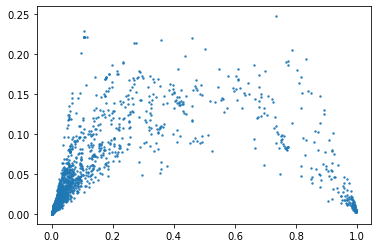

In [55]:
plt.plot(ds_pred.mean(dim='split').values.flatten(), ds_pred.std(dim='split').values.flatten(), linestyle='', marker='.', markersize=3, alpha=.8)

In [56]:
mn = ds_pred.mean(dim='split')
ds_sup['labels'] = (mn>.5).astype(float)
ds_sup = ds_sup.drop('preds')
ds_sup = ds_sup.where(((mn<0.3) + (mn>0.7)).astype(bool).all(dim='species'), drop=True)

In [64]:
ds_train_test_splits_sup = spect.cross_val_splits(ds_final, 8, random_seed=1345431, pairs=False)

In [ ]:
boosted_sup = nb10.XG2CV(patience=10)
boosted_sup.fit(ds_train_test_splits_sup, ds_sup=ds_sup, same_params_all_columns=True, n_trials=100)
boosted_sup.drop_studies()
with open(f'nb11_results/nb11-model-cv-sup2.pkl','wb') as f:
    pickle.dump(boosted_sup, f)

[I 2022-03-24 15:36:44,017] A new study created in memory with name: no-name-2f602072-bf68-4336-a835-5cf5f482636e
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-24 16:32:20,303] Trial 0 finished with value: 0.1890928300619501 and parameters: {'n_estimators': 630, 'learning_rate': 0.005782282591135946, 'max_depth': 8, 'subsample': 0.9148768201653812, 'colsample_bytree': 0.421511371396194, 'gamma': 0.0010587436930458883, 'reg_alpha': 0.13210619145673688, 'reg_lambda': 0.18924042868288918, 'min_child_weight': 0.041439309857817214, 'scale_pos_weight': 17.563707830870502, 'max_delta_step': 9.133376576032827, 'mz_threshold': 127, 'bin_width': 297, 'bin_max': 1430, 'abundance_thresh': 2.8324304465863125e-08, 'drop_he': True, 'rebase': False, 'maxscale': True, 'logscale': False}. Best is trial 0 with value: 0.1890928300619501.
[I 2022-03-24 18:39:33,084] Trial 1 finished with value: 0.17488427875123302 and parameters: {'n_estimators': 800, 'learning_rate': 0.01669827199253864, 'max_depth': 7, 'subsample': 0.7407422115296078, 'colsample_bytree': 0.8710942987652901, 'gamma': 0.08040308157959795, 'reg_alpha': 1.5125349596574178, 'reg_lambda': 

In [66]:
ds_pred_sup = boosted_sup.predict_proba(ds_val, reduce=None)

[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  3.0s


In [67]:
l = nb10.xr_loss(ds_pred_sup, ds_val.labels)
l.mean()

<xarray.DataArray ()>
array(0.15431339)

In [68]:
s = l.mean(dim='species')
s

<xarray.DataArray (split: 8)>
array([0.15478175, 0.15924955, 0.14350024, 0.15390416, 0.14898668,
       0.15102223, 0.15736598, 0.16569657])
Coordinates:
  * split    (split) int64 0 1 2 3 4 5 6 7

In [69]:
l = nb10.xr_loss(ds_pred_sup.where(s<=np.median(s), drop=True).mean(dim='split'), ds_val.labels)
l.mean()

<xarray.DataArray ()>
array(0.14140367)

In [71]:
l = nb10.xr_loss(ds_pred_sup.mean(dim='split'), ds_val.labels)
l.mean()

<xarray.DataArray ()>
array(0.14450452)

In [72]:
ds_train_test_splits_sup = spect.cross_val_splits(ds_final, 8, random_seed=1345433, pairs=False)

In [73]:
boosted_sup2 = nb10.XG2CV(patience=10)
boosted_sup2.fit(ds_train_test_splits_sup, ds_sup=ds_sup, same_params_all_columns=True, n_trials=100)
boosted_sup2.drop_studies()
with open(f'nb11_results/nb11-model-cv-sup3.pkl','wb') as f:
    pickle.dump(boosted_sup2, f)

[I 2022-03-25 10:29:53,044] A new study created in memory with name: no-name-97f61573-97a9-4f64-b1d5-067107532397
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-25 10:33:28,255] Trial 0 finished with value: 0.18174643657654377 and parameters: {'n_estimators': 790, 'learning_rate': 0.03518981503073082, 'max_depth': 4, 'subsample': 0.8848555499319952, 'colsample_bytree': 0.7533972413680767, 'gamma': 0.0056188724378892115, 'reg_alpha': 3.0872110674923636, 'reg_lambda': 0.04425169706465711, 'min_child_weight': 0.02708111135855224, 'scale_pos_weight': 16.214183346569758, 'max_delta_step': 3.5366160199054217, 'mz_threshold': 105, 'bin_width': 36, 'bin_max': 1210, 'abundance_thresh': 0.014755893164795836, 'drop_he': False, 'rebase': True, 'maxscale': True, 'logscale': True}. Best is trial 0 with value: 0.18174643657654377.
[I 2022-03-25 10:35:03,049] Trial 1 finished with value: 0.1701066945445419 and parameters: {'n_estimators': 900, 'learning_rate': 0.09769757966300142, 'max_depth': 4, 'subsample': 0.7612261075323843, 'colsample_bytree': 0.4448298558704835, 'gamma': 0.002419508054482696, 'reg_alpha': 0.12076281110933079, 'reg_lambda': 0.

In [78]:
ds_pred_sup2 = boosted_sup2.predict_proba(ds_val, reduce=None)

[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  4.0s


In [79]:
l = nb10.xr_loss(ds_pred_sup2, ds_val.labels)
l.mean()

<xarray.DataArray ()>
array(0.16296493)

In [80]:
s = l.mean(dim='species')
s

<xarray.DataArray (split: 8)>
array([0.16941188, 0.15933633, 0.15967299, 0.16183297, 0.16869082,
       0.16516092, 0.15792929, 0.16168421])
Coordinates:
  * split    (split) int64 0 1 2 3 4 5 6 7

In [83]:
l = nb10.xr_loss(ds_pred_sup2.mean(dim='split'), ds_val.labels)
l.mean()

<xarray.DataArray ()>
array(0.15448171)

In [84]:
l = nb10.xr_loss(ds_pred_sup.mean(dim='split'), ds_val.labels)
l.mean()

<xarray.DataArray ()>
array(0.14450452)

In [85]:
l = nb10.xr_loss(0.5*(ds_pred_sup + ds_pred_sup2).mean(dim='split'), ds_val.labels)
l.mean()

<xarray.DataArray ()>
array(0.14811087)